In [1]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
%matplotlib inline

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
multiplier = 50
min_tick = 0.25

In [3]:
#periods = [5, 10, 20]#, 40, 80] #, 160, 320] # 320] # number of periods for breakout rule
periods = [10]
ema_fast = 120 # number of periods for moving average filter
sl_atr = 1 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 60 # interval in minutes to be used to define volume candle

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

63604.29326641914

In [5]:
#vol_candles = group_by_time(contract, time_int)
vol_candles = group_by_volume(contract, avg_vol)
data = pd.DataFrame(vol_candles.close)
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()

In [6]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

In [7]:
def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).apply(np.floor)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
  

In [8]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

In [9]:
signals['value'] = signals['close'] * signals['signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

In [10]:
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, atr_periods)

In [11]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * sl_atr
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [12]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [13]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(2541.75, 2004.5, 4546.25)

In [14]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(4186, 3192, 0.5673624288425048)

In [15]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(14823.5, -10277.25, 1.4423605536500523)

In [16]:
pnl_m.sort_values().head(20)

label
3226   -50.00
8671   -24.25
8641   -24.00
3228   -21.75
8629   -21.25
3202   -21.00
3223   -18.75
3201   -18.00
8693   -17.75
8600   -17.75
3204   -17.75
7787   -17.50
8444   -17.50
3332   -17.50
8802   -17.00
4121   -16.50
8643   -16.50
8363   -16.00
3287   -16.00
8503   -15.50
Name: pnl, dtype: float64

In [17]:
pnl_p.sort_values(ascending=False).head(20)

label
3222     44.00
8138     36.50
12452    29.50
3225     24.00
7607     23.75
8697     23.50
8506     23.50
5679     23.00
3221     22.50
3199     22.00
11512    21.25
12075    20.50
12623    19.75
8425     19.50
7005     19.00
12198    19.00
11098    18.25
3208     18.25
11884    18.25
8704     18.00
Name: pnl, dtype: float64

In [18]:
signals['date'] = vol_candles['date']

In [19]:
signals.set_index('date', inplace=True)

In [20]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-09-01,NaN,0.00
2019-09-02,2897.75,0.00
2019-09-03,2907.00,-13.75
2019-09-04,2937.75,30.75
2019-09-05,2958.00,20.25


In [21]:
daily.head()

,close,pnl
date,,
2017-05-17,2375.5,0.0
2017-05-18,NaN,0.0
2017-05-19,NaN,0.0
2017-05-20,NaN,0.0
2017-05-21,NaN,0.0


In [22]:
daily['dollars'] = 0
daily.iloc[0,2] = 15000

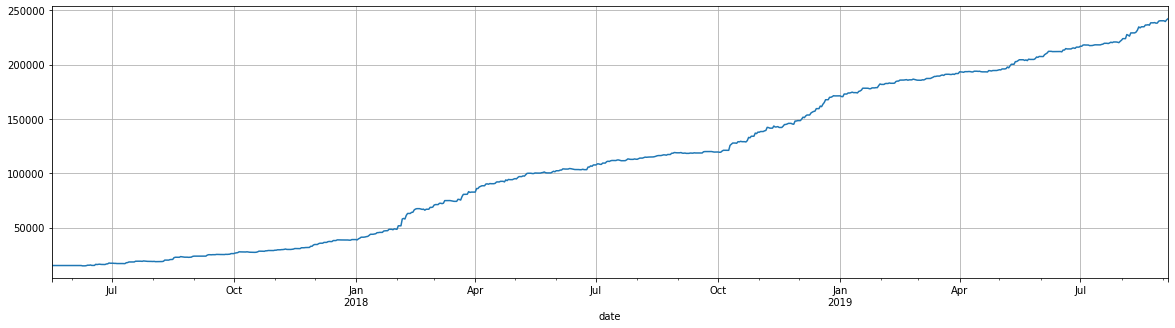

In [23]:
daily['dollars'] = 15000 + daily.pnl.cumsum() * multiplier
daily['return'] = daily.dollars.pct_change()
daily.dollars.plot(figsize=(20,5), grid=True);

In [24]:
daily['absolute'] = daily['pnl'] * multiplier/10000

In [25]:
perf_stats(daily['absolute'].iloc[40:])

Annual return          6.522935e+02
Cumulative returns     9.103199e+08
Annual volatility      1.114786e+00
Sharpe ratio           6.378865e+00
Calmar ratio           4.702062e+03
Stability              9.890276e-01
Max drawdown          -1.387250e-01
Omega ratio            5.911829e+00
Sortino ratio          2.903859e+01
Skew                   2.675499e+00
Kurtosis               1.147489e+01
Tail ratio             4.323102e+00
Daily value at risk   -1.122313e-01
dtype: float64

In [26]:
perf_stats(daily['return'].iloc[40:])

Annual return           1.348840
Cumulative returns     14.144531
Annual volatility       0.156449
Sharpe ratio            5.543074
Calmar ratio           40.650338
Stability               0.922912
Max drawdown           -0.033182
Omega ratio             6.256787
Sortino ratio          29.138766
Skew                    4.554915
Kurtosis               35.716023
Tail ratio              5.676574
Daily value at risk    -0.016269
dtype: float64

In [27]:
number_of_trades

1205

In [28]:
spread = min_tick * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

17508.649999999998

In [29]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

841

In [30]:
trades_per_day = number_of_trades / days
trades_per_day

1.4328180737217597

In [31]:
pnl_in_dollars = pnl*multiplier

In [32]:
cost_of_trades / (pnl_in_dollars)

0.07702458069837777

In [33]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(0.847418639875824, 0.1599041856840068)

In [34]:
mean/std

5.2995400730187425

In [35]:
#daily.to_pickle('nq_return.pickle')